<h3> Dự đoán giá cổ phiếu sử dụng mô hình LSTM <h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
# Đọc tệp CSV
df = pd.read_csv("FPT.csv")
# có thể thay thế bằng các công ty khác nhau (MSN, VIC, PNJ)
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [3]:
# Chuyển đổi cột chứa ngày tháng năm và giờ phút thành kiểu dữ liệu datetime
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")
# Tạo hai cột mới cho ngày và giờ
df["date"] = df["Date/Time"].dt.date
df["time"] = df["Date/Time"].dt.time
df_clean = df.groupby('date').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_clean

,Open,High,Low,Close,Volume
date,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2019-01-02,31.19,31.45,30.70,30.74,459120
...,...,...,...,...,...
2020-12-16,57.20,57.50,57.00,57.10,1995530
2020-12-17,56.90,57.00,56.00,56.50,3594500
2020-12-18,56.50,57.00,56.50,56.90,1532820


In [4]:
# Chọn các cột giá trị để dự đoán
data = df_clean.filter(['Open'])

# Chia dữ liệu thành tập train và test
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

chia dữ liệu thành 2 phần: tập huấn luyện (train) và tập kiểm tra (test)

In [5]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

sử dụng MinMaxScaler để chuẩn hóa dữ liệu thành phạm vi từ 0 đến 1

In [6]:
# Hàm tạo dữ liệu cho mô hình LSTM
def create_lstm_data(data, look_back= 60):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

hàm này được sử dụng để tạo dữ liệu cho mô hình LSTM. Hàm này có 2 đối số đầu vào là "data" và "look_back". "data" là dữ liệu đầu vào của mô hình, "look_back" là số ngày trước đó mà mô hình sẽ sử dụng để dự đoán giá trong ngày tiếp theo.

In [7]:
# Tạo dữ liệu cho mô hình LSTM
look_back = 60
X_train, Y_train = create_lstm_data(train_data_scaled, look_back)
X_test, Y_test = create_lstm_data(test_data_scaled, look_back)


In [8]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
11/11 [==============================] - 4s 45ms/step - loss: 0.1496
Epoch 2/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0256
Epoch 3/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0231
Epoch 4/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0163
Epoch 5/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0152
Epoch 6/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0138
Epoch 7/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0123
Epoch 8/100
11/11 [==============================] - 0s 42ms/step - loss: 0.0133
Epoch 9/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0135
Epoch 10/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0123
Epoch 11/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0119
Epoch 12/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0123
Epoch 13/100
11/11 [=====

In [10]:
# Dự đoán giá trị
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 11ms/step


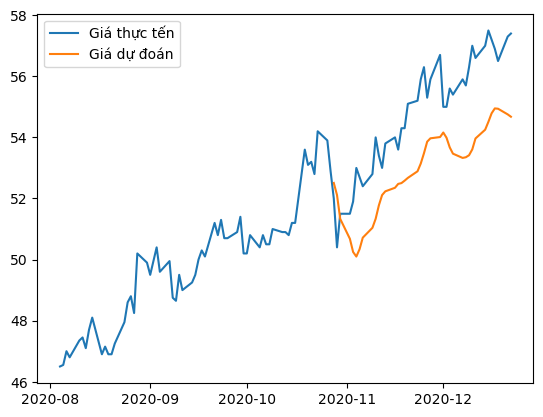

In [11]:
# Vẽ biểu đồ dự đoán và giá trị thực tế
plt.plot(test_data.index, test_data['Open'], label='Giá thực tến')
plt.plot(test_data.index[look_back:], predictions, label='Giá dự đoán')
plt.legend()
plt.show()

In [13]:
# Dự đoán giá trị trong n ngày tiếp theo
def predict_next_n_days(n, model, data, scaler):
    last_n_days = data[-60:]
    predictions = []
    for i in range(n):
        last_n_days_scaled = scaler.transform(last_n_days)
        X_test = np.array([last_n_days_scaled])
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        next_day_prediction = model.predict(X_test)
        next_day_prediction = scaler.inverse_transform(next_day_prediction)
        predictions.append(next_day_prediction[0][0])
        last_n_days = np.append(last_n_days, next_day_prediction, axis=0)[1:]
    return predictions

# Dự đoán giá trị trong N ngày tiếp theo
n_days = 5
predicted_values = predict_next_n_days(n_days, model, data, scaler)
print(predicted_values)

1/1 [==============================] - 0s 23ms/step
[54.69039, 54.194805, 53.449574, 52.610966, 51.761967]
